<a href="https://colab.research.google.com/github/YLiu-101/FutureMakers2022/blob/main/daily-nb/Day_15_Affective_Computing_SV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

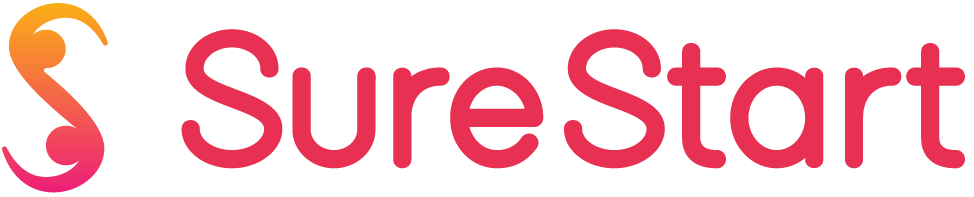

#Day 15 Objectives:
* Introduction to Affective Computing. 
* Introduction to emotion estimation from speech parameters.


#Affective Computing

Affective computing is the study and development of systems and devices that can recognize, interpret, process, and simulate human affects. It is an interdisciplinary field spanning computer science, psychology, and cognitive science. While the origins of the field may be traced as far back as to early philosophical inquiries into emotion (“affect” is, basically, a synonym for “emotion.”), the more modern branch of computer science originated with Rosalind Picard’s 1995 paper on affective computing. A motivation for the research is the ability to simulate empathy. The machine should interpret the emotional state of humans and adapt its behavior to them, giving an appropriate response for those emotions.

Affective computing technologies sense the emotional state of a user (via sensors, microphone, cameras and/or software logic) and respond by performing specific, predefined product/service features, such as changing a quiz or recommending a set of videos to fit the mood of the learner.

The more computers we have in our lives the more we’re going to want them to behave politely, and be socially smart. We don’t want it to bother us with unimportant information. That kind of common-sense reasoning requires an understanding of the person’s emotional state.

In [ ]:
# To extract data
import os
import zipfile

# To read and manage audio files
import pickle
import librosa
import librosa.display

# For data manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.utils import to_categorical
# Machine Learning library
import tensorflow as tf

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Visualization
import matplotlib.pyplot as plt
import IPython.display as ipd  # To play sound in the notebook

## Question 1
This is the first time we are dealing with an audio dataset. Without looking ahead, what do you think is a good way to represent audio files as inputs which can be fed into a neural network?

< *A good way to deal with audio files is to represent them as a waveform? Perhaps we can represent them as an image by translating the sound intensities into gray-scaled pixels.* >

#Dataset - RAVDESS dataset
RAVDESS is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = * *  fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong * *  intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)
At my early beginings embarking on this journey, I learnt through the hard way that male and female speakers have to be trained seperately or the model will struggle to get a good accuracy. From reading a few blogs and articles, it seems female has a higher pitch that male. So if we don't tag the gender label to the audio file, it won't be able to detect anger or fear if it was a male speaker. It will just get bucketed into neutral

Lets specifically model the 2 speakers seperately. Note that there's a 'calm' emotion and a 'neutral' emotion as seperate. I don't really know the difference but for now, I'll just combined them into the same category.

In [ ]:
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip $HOME/RAVDESS/Audio_Speech_Actors_01-24.zip
local_zip = '/content/Audio_Speech_Actors_01-24.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
os.mkdir('/content/actor_folders')
zip_ref.extractall('/content/actor_folders')
zip_ref.close()
actor_folders = '/content/actor_folders/'

--2022-08-15 22:20:30--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  12.6MB/s    in 17s     

2022-08-15 22:20:49 (11.7 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]

/root/RAVDESS/Audio_Speech_Actors_01-24.zip: Scheme missing.
FINISHED --2022-08-15 22:20:49--
Total wall clock time: 19s
Downloaded: 1 files, 199M in 17s (11.7 MB/s)


## Question 2

We have downloaded a dataset in the above manner when downloading the *Cats Vs Dogs* dataset. According to you, what are the ways we can pre-process (segregate) this dataset into its classes? In other words, what are the potential classes this data can be categorized into?

< *Happy vs Sad vs Angry. Or possibly a sliding scale of sentiments. It depends on the labels in the dataset* >

#Loading the dataset

In [ ]:
dir_list = os.listdir(actor_folders)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(actor_folders + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(actor_folders + i + '/' + f)

RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_calm          96
male_surprise      96
male_disgust       96
male_angry         96
male_sad           96
male_happy         96
male_fear          96
female_surprise    96
female_calm        96
female_happy       96
female_disgust     96
female_angry       96
female_sad         96
female_fear        96
male_neutral       48
female_neutral     48
Name: labels, dtype: int64

#Explore the data
Let's do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with. And how different they are to SAVEE as we go along. Let's start with a fearful track.

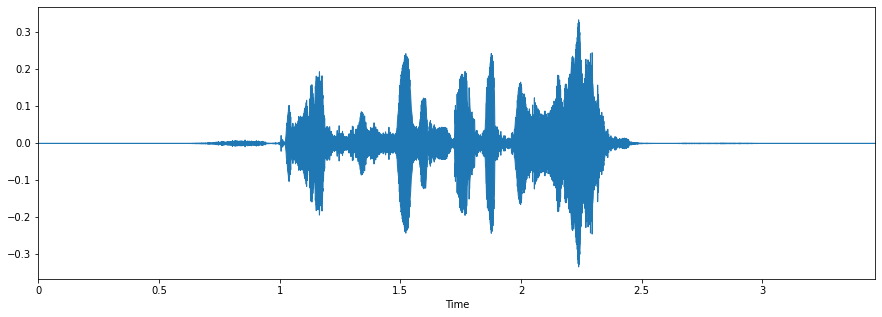

In [ ]:
# Pick a fearful track
fname = actor_folders + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)


Excellent audio quality. And well acted out. I think you can genuinely feel the fear from the speaker. I do notice that there's a lot of silence between the start and end. We'll address it later in later parts. Let's play another random file, maybe a happy one this time.

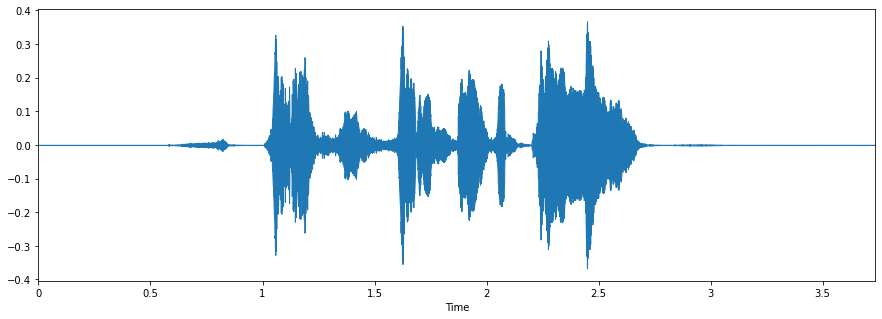

In [ ]:
# Pick a happy track
fname = actor_folders + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

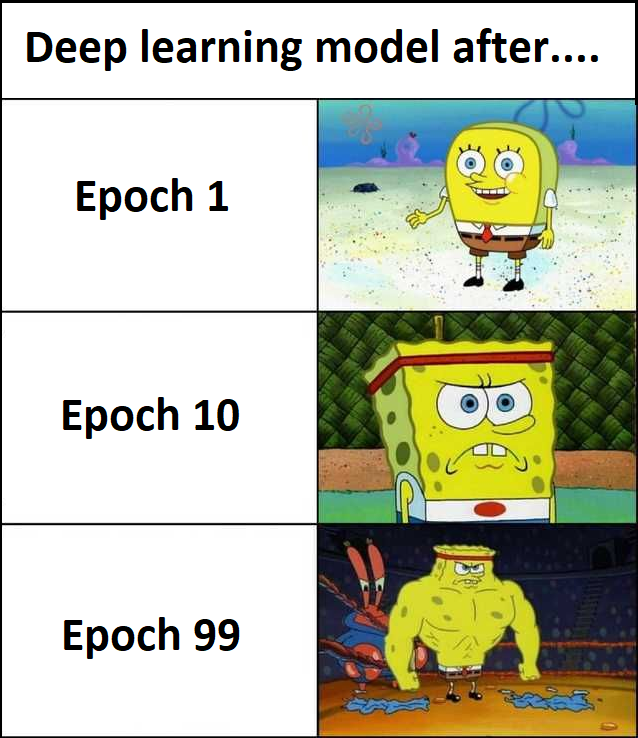

#Feature Extraction 
Broadly speaking there are two category of features:

* Time domain features

These are simpler to extract and understand, like the energy of signal, zero crossing rate, maximum amplitude, minimum energy, etc.
* Frequency based features

are obtained by converting the time based signal into the frequency domain. Whilst they are harder to comprehend, it provides extra information that can be really handy such as pitch, rhythms, melody etc. Check this infographic below:

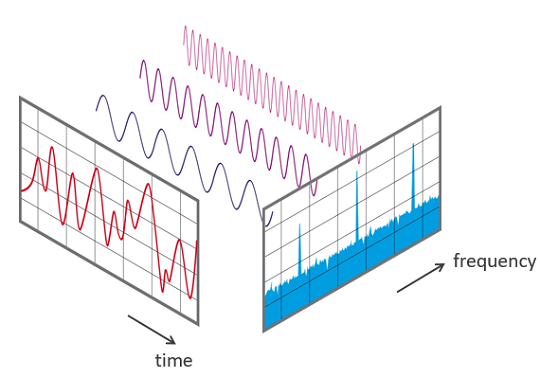

Source:https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft

Core concepts in Audio
Before diving straight to the meaty bits, I'm going to quickly introduce a few key concepts to anyone who's new to audio

* Duration
* sampling rate
* Amplitude
* Frequency

Duration is the length of the audio call in terms of time.

Sampling rate is the number of samples of audio per second, measured in Hz / KHz. This is similar to resolution in images, where the higher the resolution (or more pixels), the clearer it is. A full sampling rate is 44100 Hz (44.1 KHz) but, you don't always need to have it in at 'High Fidelity' format. A more reasonable sampling rate is 22050 Hz (22 KHz), because that is the audible sound to a human.

Amplitude is the fluctuation of the soud wave. The shorter and more frequent the waves are, the higher the pitch or frequency. Plotting the audio by time against amplitute is probably the most intuitive way of understanding the audio. However, its not the only way to represent the data or used as feature. Another equally good way of doing this is to look at it by the frequency domain, which is a nice segway to our final concept.

Frequency, the best way of understanding it is through visualising it. Imagining the audio in terms of time is probably the most intutive way of thinking about it. But frequency, although not as intuitive, is actually much more efficient as signal in the frequency domain requires much less computational space for storage. Below is a nice visualisation of how to differentiate the Time vs Frequency domain



# Mel-Frequency Cepstral Coefficient [MFCC]

There are many ways you can slice and dice this one feature -- MFCC. But what is MFCC? It stands for **Mel-frequency cepstral coefficient**, and it is a good "representation" of the vocal tract that produces the sound. Think of it like an x-ray of your mouth.

The most common machine learning application treats the MFCC itself as an 'image' and becomes a feature. The benefit of treating it as an image is that it provides more information, and gives one the ability to draw on transfer learning (the knowledge gained while solving one problem and applying it to a different but related problem). 

MFCC is proven to yield good accuracy for audio tasks. However, research has also shown that statistics relating to MFCCs (or any other time or frequency domain) can carry good amount of information as well. We'll be investigating MFCC here.

## Question 3
MFCC is one of a more used feature. What other features of an audio input can be used here?

And practically which features help us learn the subtleties for speech emotion recognition? Visualize the features by referring to https://librosa.org/doc/main/display.html. 

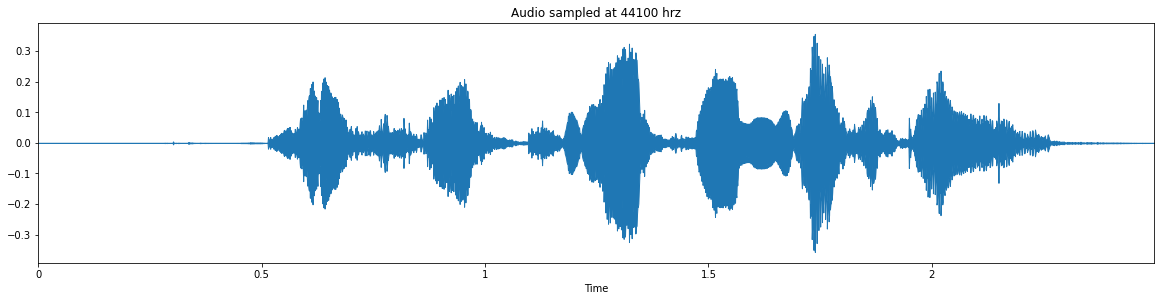

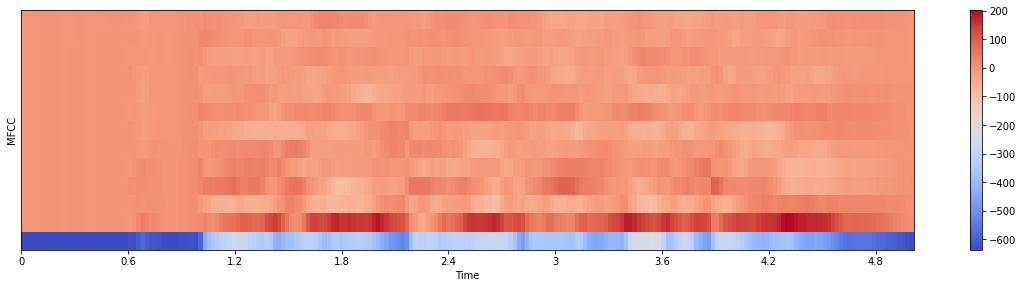

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "/content/actor_folders/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

#Deepdive
We can select a few examples and visualise the MFCC. Let's take 2 different emotions and 2 different genders, and play it just to get a feel for what we are dealing with. I.e., whether the data (audio) quality is good for our classification task. It gives us an early insight as to how likely our classifier is going to be successful.

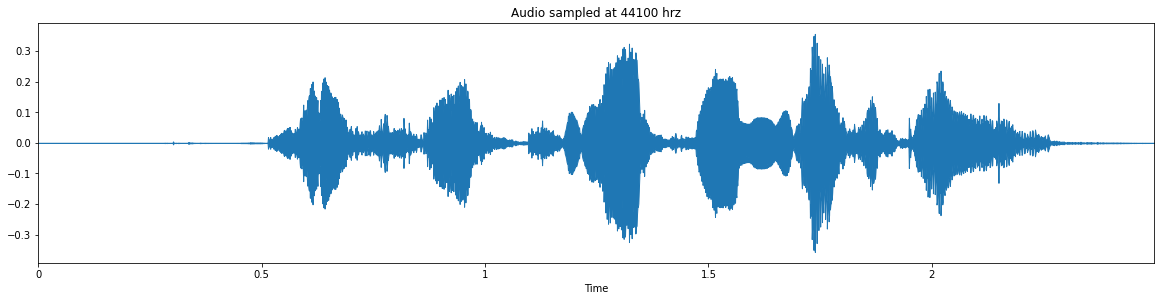

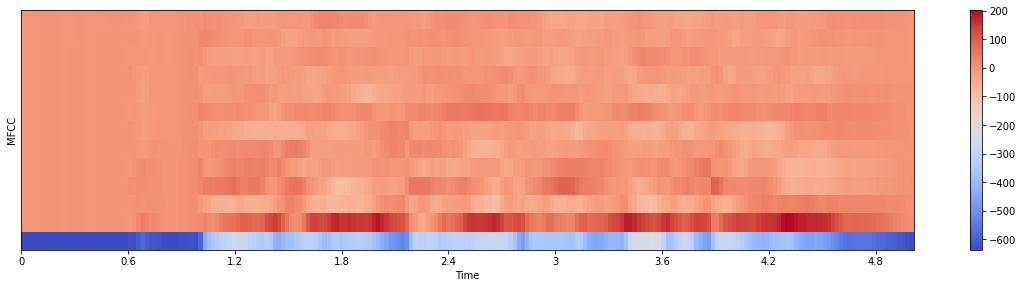

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "/content/actor_folders/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

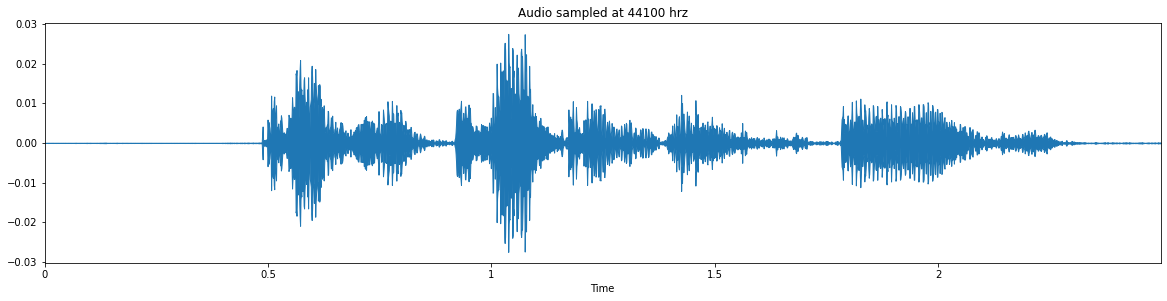

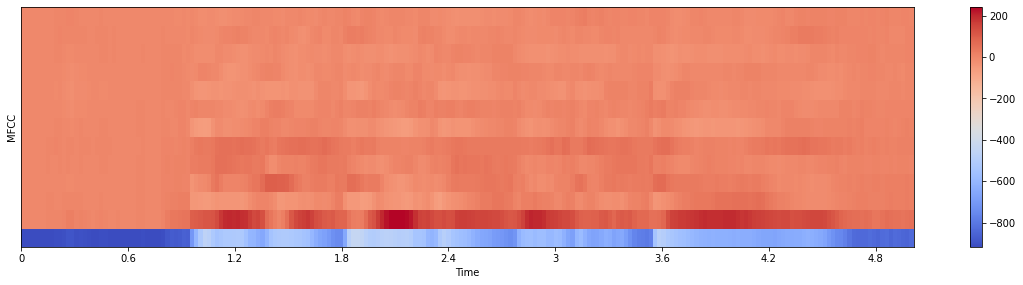

In [ ]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "/content/actor_folders/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

#Statistical features
Now we've seen the shape of an MFCC output for each file, and it's a 2D matrix format with MFCC bands on the y-axis and time on the x-axis, representing the MFCC bands over time. To simplify things, what we're going to do is take the mean across each band over time. In other words, row means. 

But how does it present as a distinctive feature?

Look at the MFCC plot above, the first band at the bottom is the most distinctive band over the other bands. Since the time window is a short one, the changes observed overtime does not vary greatly. The key feature is capturing the information contained in the various bands. Let's plot the mean of each of the band and display it as a time series plot to illustrate the point.

We'll compare the *angry female* and *angry male* for the same sentence uttered.

216
216


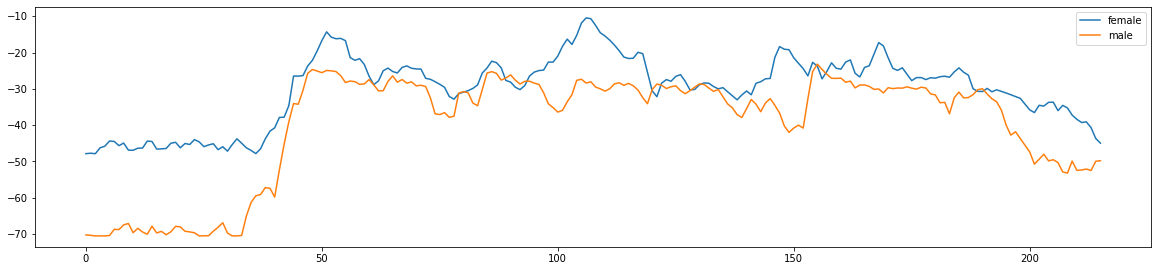

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "/content/actor_folders/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "/content/actor_folders/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

So we've already seen the shape of an MFCC output for each file, and it's a 2D matrix of the number of bands by time. In order to optimise space and memory, we're going to read each audio file, extract its mean across all MFCC bands by time, and just keep the extracted features, dropping the entire audio file data.

In [ ]:
df = pd.DataFrame(columns=['feature'])
# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(RAV_df.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

1440


,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-56.872803, -56.872803, -56.872803, -56.87280..."
2,"[-51.51084, -52.34763, -52.809456, -53.146015,..."
3,"[-40.796883, -40.78967, -40.808334, -40.876545..."
4,"[-62.104954, -62.104954, -62.104954, -62.03812..."


#Data processing
Like any good standard deep learning workflow. Because of the general saying of *garbage in grabage out*, data processing is the most important step. So let's start manipulating the data into a workable format and pad out any issues we find.

In [ ]:
# Now extract the mean bands to its own feature columns
df = pd.concat([RAV_df,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_calm,RAVDESS,/content/actor_folders/Actor_01/03-01-02-01-01...,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-58.802547,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.083252,-60.235165
1,male_surprise,RAVDESS,/content/actor_folders/Actor_01/03-01-08-02-01...,-56.872803,-56.872803,-56.872803,-56.872803,-56.872803,-56.872803,-56.872803,...,-52.086552,-53.075466,-50.191605,-52.828239,-52.267193,-52.902489,-55.671547,-54.770939,-55.084713,-54.702595
2,male_disgust,RAVDESS,/content/actor_folders/Actor_01/03-01-07-02-01...,-51.510841,-52.347630,-52.809456,-53.146015,-52.315140,-52.374695,-52.926365,...,-24.761080,-25.695751,-25.518898,-27.818911,-27.568684,-26.828836,-27.712048,-27.944407,-28.680454,-27.750122
3,male_angry,RAVDESS,/content/actor_folders/Actor_01/03-01-05-02-02...,-40.796883,-40.789669,-40.808334,-40.876545,-40.619694,-40.420124,-40.692852,...,-23.363058,-21.875113,-24.762779,-29.518728,-27.211128,-16.296978,-15.058402,-19.382408,-19.939528,-16.054724
4,male_sad,RAVDESS,/content/actor_folders/Actor_01/03-01-04-02-01...,-62.104954,-62.104954,-62.104954,-62.038120,-62.104954,-62.104954,-62.104954,...,-57.709579,-60.358253,-61.090824,-62.026714,-61.804924,-61.251534,-59.135971,-61.460106,-62.104954,-62.104954


In [ ]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(1440, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_calm,RAVDESS,/content/actor_folders/Actor_01/03-01-02-01-01...,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-58.802547,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.083252,-60.235165
1,male_surprise,RAVDESS,/content/actor_folders/Actor_01/03-01-08-02-01...,-56.872803,-56.872803,-56.872803,-56.872803,-56.872803,-56.872803,-56.872803,...,-52.086552,-53.075466,-50.191605,-52.828239,-52.267193,-52.902489,-55.671547,-54.770939,-55.084713,-54.702595
2,male_disgust,RAVDESS,/content/actor_folders/Actor_01/03-01-07-02-01...,-51.510841,-52.347630,-52.809456,-53.146015,-52.315140,-52.374695,-52.926365,...,-24.761080,-25.695751,-25.518898,-27.818911,-27.568684,-26.828836,-27.712048,-27.944407,-28.680454,-27.750122
3,male_angry,RAVDESS,/content/actor_folders/Actor_01/03-01-05-02-02...,-40.796883,-40.789669,-40.808334,-40.876545,-40.619694,-40.420124,-40.692852,...,-23.363058,-21.875113,-24.762779,-29.518728,-27.211128,-16.296978,-15.058402,-19.382408,-19.939528,-16.054724
4,male_sad,RAVDESS,/content/actor_folders/Actor_01/03-01-04-02-01...,-62.104954,-62.104954,-62.104954,-62.038120,-62.104954,-62.104954,-62.104954,...,-57.709579,-60.358253,-61.090824,-62.026714,-61.804924,-61.251534,-59.135971,-61.460106,-62.104954,-62.104954


Next we will split the data into 2 parts, one for training and one for validation. This ensures we measure the model's performance at its true accuracy.


In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
1050,-51.416233,-50.766010,-50.452049,-51.310093,-53.983238,-55.266525,-54.837303,-54.061428,-54.337994,-56.573269,...,-29.766817,-29.102522,-28.178926,-29.851540,-30.996429,-31.725912,-31.804796,-32.563694,-22.284245,-15.954228
1089,-48.061653,-48.061653,-47.749474,-48.061653,-48.061653,-47.751152,-47.381592,-45.814175,-44.860844,-45.053623,...,-45.708092,-46.376602,-45.206284,-44.076164,-42.985359,-41.877590,-42.161785,-43.131104,-43.436729,-44.394455
1272,-61.293968,-61.698799,-63.505295,-61.008118,-58.804459,-57.963848,-57.513115,-57.650391,-59.734062,-61.305477,...,-58.592293,-59.425705,-59.088020,-61.430439,-66.198250,-64.429771,-59.176846,-56.783627,-58.191833,-62.347942
1029,-59.146694,-59.146694,-59.146694,-59.146694,-59.146694,-59.146694,-59.071358,-58.001377,-58.183006,-58.731560,...,-44.588726,-47.246452,-48.395287,-47.873047,-49.259541,-48.560402,-49.603779,-51.575798,-57.678341,-59.146694
1336,-64.286209,-64.286209,-64.286209,-64.286209,-64.286209,-64.286209,-64.286209,-64.286209,-64.286209,-64.286209,...,-64.286209,-64.286209,-64.286209,-64.286209,-64.286209,-64.286209,-64.286209,-64.286209,-64.286209,-64.286209
328,-59.399719,-59.468426,-59.668514,-59.724754,-60.086857,-59.951866,-59.503452,-59.673508,-59.957584,-60.216038,...,-46.127754,-45.867649,-43.998352,-46.022446,-48.725399,-52.320072,-51.886345,-54.411865,-58.322506,-55.231060
318,-47.663162,-47.677952,-47.639664,-47.585598,-47.357422,-47.152412,-46.562237,-45.171627,-44.318336,-44.852982,...,-42.013138,-40.153099,-41.010918,-40.840233,-41.635872,-41.761681,-41.185776,-41.830505,-44.061161,-44.245094
1108,-50.396259,-52.037209,-53.323410,-53.682289,-53.738369,-52.724144,-51.939064,-51.224201,-52.601494,-52.438293,...,-27.821594,-28.126060,-28.802042,-28.739342,-28.627663,-29.072733,-29.154388,-29.548170,-29.643669,-27.837679
1176,-58.780411,-58.780411,-58.780411,-58.780411,-58.780411,-58.780411,-58.780411,-58.780411,-58.780411,-58.780411,...,-53.177750,-53.421654,-53.155045,-55.452080,-56.329563,-55.669720,-56.555035,-55.602581,-55.444908,-56.373787
12,-61.862686,-61.862686,-61.862686,-61.862686,-61.862686,-61.862686,-61.862686,-61.862686,-61.862686,-61.862686,...,-61.862686,-61.862686,-61.761757,-60.348843,-60.160908,-61.384720,-60.519608,-61.496365,-61.862686,-60.532001


In [ ]:
# Lets do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
1050,0.518391,0.573153,0.615997,0.513687,0.189079,0.024444,0.069564,0.161055,0.124313,-0.143656,...,1.399250,1.474280,1.566327,1.448106,1.381669,1.345741,1.362085,1.328632,1.969227,2.211056
1089,0.910103,0.892158,0.936721,0.899412,0.888487,0.910690,0.938516,1.116713,1.228138,1.193298,...,0.029218,-0.005860,0.110276,0.231093,0.348688,0.466644,0.466541,0.411522,0.305353,0.184876
1272,-0.635025,-0.716474,-0.933081,-0.637873,-0.380363,-0.293636,-0.242297,-0.254820,-0.504180,-0.692869,...,-1.078082,-1.123979,-1.076785,-1.253684,-1.651364,-1.486289,-1.004711,-0.773335,-0.855297,-1.094193
1029,-0.384289,-0.415429,-0.415829,-0.416845,-0.420785,-0.433123,-0.423908,-0.295491,-0.323525,-0.394144,...,0.125419,-0.080393,-0.162424,-0.093757,-0.191904,-0.112062,-0.176950,-0.321365,-0.814905,-0.866125
1336,-0.984426,-1.021684,-1.025755,-1.027119,-1.027822,-1.039197,-1.031691,-1.023752,-1.034379,-1.038809,...,-1.567431,-1.540455,-1.521295,-1.498014,-1.486620,-1.473857,-1.446505,-1.424458,-1.334686,-1.232282
328,-0.413834,-0.453380,-0.477756,-0.485485,-0.531830,-0.528072,-0.474268,-0.489250,-0.530214,-0.566430,...,-0.006849,0.037750,0.213569,0.064575,-0.145881,-0.437635,-0.374318,-0.567497,-0.865576,-0.587162
318,0.956634,0.937419,0.949753,0.955939,0.971665,0.981296,1.034010,1.191169,1.291325,1.216585,...,0.346771,0.527405,0.469032,0.507948,0.464961,0.476682,0.550934,0.524396,0.256235,0.195517
1108,0.637493,0.423203,0.275242,0.232008,0.218001,0.324252,0.407350,0.489821,0.326567,0.336244,...,1.566427,1.557948,1.513043,1.543262,1.585765,1.575496,1.591259,1.590339,1.390328,1.364438
1176,-0.341518,-0.372222,-0.372361,-0.373352,-0.377523,-0.389929,-0.389999,-0.385762,-0.393106,-0.399813,...,-0.612743,-0.609519,-0.569442,-0.742194,-0.801066,-0.727702,-0.778009,-0.670836,-0.639221,-0.668573
12,-0.701433,-0.735806,-0.738146,-0.739346,-0.741576,-0.753405,-0.749233,-0.742924,-0.752106,-0.757538,...,-1.359148,-1.332794,-1.305423,-1.161146,-1.131179,-1.222599,-1.120816,-1.182337,-1.144050,-0.964819


## Question 4

In the above cell, what form of data normalization is performed on the data? 

Are there any other pre-processing steps you think are necessary to perform on this data?

Answer: We could also bound the values between zero and one using the min-max method. The preprocessing that was done makes the mean zero and standard deviation equal to 1.

In [ ]:
""" Enter your code for Question 4 here """

' Enter your code for Question 4 here '

We need to expand the input to a third dimension (`axis=2`) for it to be compatible with the input shape expected by `Conv1D`.

In [ ]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickle the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close() 

(1080, 216)
['female_angry' 'female_calm' 'female_disgust' 'female_fear'
 'female_happy' 'female_neutral' 'female_sad' 'female_surprise'
 'male_angry' 'male_calm' 'male_disgust' 'male_fear' 'male_happy'
 'male_neutral' 'male_sad' 'male_surprise']


In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1080, 216, 1)

In [ ]:
# New model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv1D(256, 8, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(8)))
model.add(tf.keras.layers.Conv1D(128, 8, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv1D(128, 8, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv1D(128, 8, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv1D(128, 8, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(8)))
model.add(tf.keras.layers.Conv1D(64, 8, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv1D(64, 8, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16)) # Target class number
model.add(tf.keras.layers.Activation('softmax'))

opt = tf.keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          2304      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 256)          524544    
                                                                 
 batch_normalization (BatchN  (None, 216, 256)         1024      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 216, 256)          0         
                                                                 
 dropout (Dropout)           (None, 216, 256)          0         
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
68/68 [==============================] - 15s 22ms/step - loss: 2.4832 - accuracy: 0.1528 - val_loss: 2.4610 - val_accuracy: 0.1972
Epoch 2/100
68/68 [==============================] - 1s 13ms/step - loss: 2.2117 - accuracy: 0.2157 - val_loss: 2.2066 - val_accuracy: 0.2194
Epoch 3/100
68/68 [==============================] - 1s 13ms/step - loss: 2.0500 - accuracy: 0.2565 - val_loss: 2.2000 - val_accuracy: 0.2361
Epoch 4/100
68/68 [==============================] - 1s 12ms/step - loss: 1.9698 - accuracy: 0.2991 - val_loss: 2.1687 - val_accuracy: 0.2444
Epoch 5/100
68/68 [==============================] - 1s 13ms/step - loss: 1.8646 - accuracy: 0.3324 - val_loss: 2.1548 - val_accuracy: 0.2083
Epoch 6/100
68/68 [==============================] - 1s 14ms/step - loss: 1.8145 - accuracy: 0.3306 - val_loss: 2.1964 - val_accuracy: 0.2472
Epoch 7/100
68/68 [==============================] - 1s 13ms/step - loss: 1.7453 - accuracy: 0.3556 - val_loss: 1.8797 - val_accuracy: 0.3056
Epoch

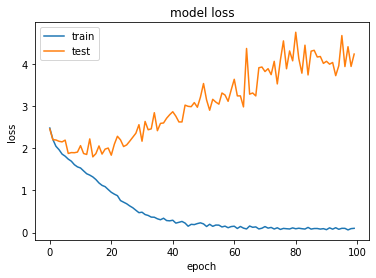

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Question 5

We had a model with 1.3 million parameters, yet our validation accuracy is below 50%. 
Propose a model which can gain better validation accuracy than 50%.

You may also change the features used.

*Hint*: Think about the audio waveform as time series data. Would LSTMs work better here?

Answer: RNNs or LSTMs might work better, since they have a better memory. 

#Model serialisation
So it's time to serialise the model for reusability. In order to save the model, we need to serialize the model object which contains the architecture metadata and its parameters (weights and biases).

In [ ]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/Emotion_Model.h5 


#Model validation

Here we will predict emotions, given the test audio data. After serialising the model above, we are going to reload it into disk. Essentially to reuse the model without having to retrain the entire model, we just need to run this section of the code if the model is saved. Since we used the same test set in the keras model, the result is essentially the same as the last epoch of 100 which is 43.80%

In [ ]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 38.06%


In [ ]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

23/23 [==============================] - 0s 3ms/step


array([14, 12,  5,  3, 14, 10,  3,  2,  2,  8, 11,  3, 10,  1, 11,  1, 10,
       12,  6,  5,  5,  5,  6, 11,  3,  8, 13,  8, 10, 10, 14,  3, 11, 10,
       15, 14,  9, 10,  2, 12,  4,  4, 11, 10, 10,  9,  1, 14,  1,  4,  5,
        0, 12,  1, 14,  3,  5,  1, 11, 12, 14,  2, 10,  3,  4,  5,  7, 12,
        3,  2,  5,  7,  5,  3, 15,  5, 14,  7,  8,  2, 10,  0,  0,  8,  0,
       14,  6,  3, 10,  7,  4,  2,  0,  3,  1, 14,  4,  9,  0,  8,  3,  3,
        9, 10, 14,  3,  3, 14, 10, 13,  1,  7,  3, 14,  0,  3, 10, 10, 11,
        9,  0,  1,  5, 14, 10, 10,  1, 10,  6,  6, 15,  8,  8, 13,  7, 15,
        7,  8,  2,  3, 11,  3, 11, 10, 14, 12, 12, 15, 13,  3,  8,  7,  5,
        9,  6, 13,  1, 13,  8,  6,  9, 13,  5,  3,  7,  3, 10,  7,  3, 14,
        7,  9,  3,  3,  8,  2,  8, 12, 12,  3,  5,  2,  3,  3,  0, 10,  0,
        5,  5,  9, 10,  1,  3,  5,  3,  3, 11,  6,  2,  5,  7, 10, 13,  5,
        8,  4,  8,  6, 13, 15, 11, 13, 11,  2,  4, 12,  0,  1, 12, 10,  0,
       14,  5,  2, 14,  3

The prediction is in the form of numbers, we'll need to append the labels to it before we run the accuracy measure.


In [ ]:
# predictions 
#preds = preds.astype(int).flatten()
#preds = (lb.inverse_transform((preds)))
#preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
preds = pd.DataFrame(preds)
finaldf = pd.concat([actual,preds])
finaldf[170:180]


,actualvalues,0
170,female_surprise,NaN
171,male_sad,NaN
172,female_fear,NaN
173,female_fear,NaN
174,male_surprise,NaN
175,female_disgust,NaN
176,male_angry,NaN
177,male_sad,NaN
178,male_happy,NaN
179,female_disgust,NaN


In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'


# **Upload this Day 15 Colab Notebook to your Github repository under "Day 15" folder. Also add your *Reflection* on today's learning in README.md**

Source: https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model